<a href="https://colab.research.google.com/github/sahilgupta001/WheatDetection/blob/master/YOLOv5_Kaggle_Test_wheat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import shutil

In [ ]:
# !pip install ensemble-boxes

In [ ]:
import torch
import sys
from ensemble_boxes import *
import glob

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo

In [ ]:
# !pip install -U -r yolov5/requirements.txt

In [ ]:
!cp -r /content/yolov5/* .

In [ ]:
!cp -r /content/yolov5/utils/* /content/utils/

In [ ]:
!cp /content/yolov5/models/yolo.py /content/models/

In [ ]:
import argparse
# sys.path.insert(0, "../input/weightedboxesfusion")
from utils.datasets import *
from utils.utils import *

In [ ]:
def my_non_max_suppression(prediction, conf_thres=0.1, iou_thres=0.6, fast=False, classes=None, agnostic=False):
    """
    Performs  Non-Maximum Suppression on inference results
    Returns detections with shape:
    
        nx6 (x1, y1, x2, y2, conf, cls)
    """
    if prediction.dtype is torch.float16:
        prediction = prediction.float()  # to FP32
    # print("Inside the function")
    # print(prediction)
    # print("==============")
    nc = prediction[0].shape[1] - 5  # number of classes
    # print(prediction[..., 4])
    # print(conf_thres)
    xc = prediction[..., 4] > conf_thres  # candidates
    # print(xc)
    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_det = 300  # maximum number of detections per image
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    fast |= conf_thres > 0.001  # fast mode
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)
    if fast:
        merge = False
    else:
        merge = True  # merge for best mAP (adds 0.5ms/img)

    t = time.time()
    output = [None] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence
        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero().t()
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # If none remain process next image
        n = x.shape[0]  # number of boxes
        if not n:
            continue

        # Sort by confidence
        # x = x[x[:, 4].argsort(descending=True)]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.boxes.nms(boxes, scores, iou_thres)
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            try:  # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy
            except:  # possible CUDA error https://github.com/ultralytics/yolov3/issues/1139
                print(x, i, x.shape, i.shape)
                pass

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            break  # time limit exceeded
    return output

In [ ]:
def detect(save_img=False):
    weights, imgsz = opt.weights,opt.img_size
    source = '/content/drive/My Drive/wheat_detection_kaggle/test'
    
    # Initialize
    device = torch_utils.select_device(opt.device)
    half = False
    # Load model

    model = torch.load(weights, map_location=device)['model'].to(device).float().eval()

    dataset = LoadImages(source, img_size=1024)

    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    all_path=[]
    all_bboxex =[]
    all_score =[]
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        bboxes_2 = []
        score_2 = []
        if True:
            pred = model(img)[0]
            pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=None, agnostic=False)
            t2 = torch_utils.time_synchronized()
            bboxes = []
            score = []
            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, '', im0s
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class

                    for *xyxy, conf, cls in det:
                        if True:  # Write to file
                            xywh = torch.tensor(xyxy).view(-1).numpy()  # normalized xywh
                            bboxes.append(xywh)
                            score.append(conf)
            bboxes_2.append(bboxes)
            score_2.append(score)
        all_path.append(path)
        all_score.append(score_2)
        all_bboxex.append(bboxes_2)
    return all_path,all_score,all_bboxex

In [ ]:
if __name__ == '__main__':
    class opt:
        weights = "/content/drive/My Drive/new/last4.pt"
        img_size = 1024
        conf_thres = 0.5
        iou_thres = 0.94
        augment = True
        device = '0'
        classes=None
        agnostic_nms = True
        
    opt.img_size = check_img_size(opt.img_size)
    
    with torch.no_grad():
        res = detect()

Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.common.Focus' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.common.Conv' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and u

image 1/10 /content/drive/My Drive/wheat_detection_kaggle/test/2fd875eaa.jpg: image 2/10 /content/drive/My Drive/wheat_detection_kaggle/test/348a992bb.jpg: image 3/10 /content/drive/My Drive/wheat_detection_kaggle/test/51b3e36ab.jpg: image 4/10 /content/drive/My Drive/wheat_detection_kaggle/test/51f1be19e.jpg: image 5/10 /content/drive/My Drive/wheat_detection_kaggle/test/53f253011.jpg: image 6/10 /content/drive/My Drive/wheat_detection_kaggle/test/796707dd7.jpg: image 7/10 /content/drive/My Drive/wheat_detection_kaggle/test/aac893a91.jpg: image 8/10 /content/drive/My Drive/wheat_detection_kaggle/test/cb8d261a3.jpg: image 9/10 /content/drive/My Drive/wheat_detection_kaggle/test/cc3532ff6.jpg: image 10/10 /content/drive/My Drive/wheat_detection_kaggle/test/f5a1f0358.jpg: 

In [ ]:
!python detect.py --source /content/drive/My\ Drive/wheat_detection_kaggle/test --weights '/content/drive/My Drive/new/last3.pt' --img 1024 --conf 0.5

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', img_size=1024, iou_thres=0.5, output='inference/output', save_txt=False, source='/content/drive/My Drive/wheat_detection_kaggle/test', update=False, view_img=False, weights=['/content/drive/My Drive/new/last3.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.common.Focus' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump

In [ ]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'


import warnings
import numpy as np
from numba import jit

@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):

        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            exit()

        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            exit()

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            x1 = float(box_part[0])
            y1 = float(box_part[1])
            x2 = float(box_part[2])
            y2 = float(box_part[3])
            # Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            # if x1 < 0:
            #     warnings.warn('X1 < 0 in box. Set it to 0.')
            #     x1 = 0
            # if x1 > 1:
            #     warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
            #     x1 = 1
            # if x2 < 0:
            #     warnings.warn('X2 < 0 in box. Set it to 0.')
            #     x2 = 0
            # if x2 > 1:
            #     warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
            #     x2 = 1
            # if y1 < 0:
            #     warnings.warn('Y1 < 0 in box. Set it to 0.')
            #     y1 = 0
            # if y1 > 1:
            #     warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
            #     y1 = 1
            # if y2 < 0:
            #     warnings.warn('Y2 < 0 in box. Set it to 0.')
            #     y2 = 0
            # if y2 > 1:
            #     warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
            #     y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            b = [int(label), float(score) * weights[t], x1, y1, x2, y2]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box
    """

    box = np.zeros(6, dtype=np.float32)
    conf = 0
    conf_list = []
    for b in boxes:
        box[2:] += (b[1] * b[2:])
        conf += b[1]
        conf_list.append(b[1])
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[2:], new_box[2:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def my_weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers.
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value
    :param allows_overflow: false if we want confidence score not exceed 1.0

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2).
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''
    # print("Hellloooo")
    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max']:
        print('Unknown conf_type: {}. Must be "avg" or "max"'.format(conf_type))
        exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []

        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())

        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            if not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(weights.sum(), len(new_boxes[i])) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(new_boxes[i]) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))

    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 2:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels


In [ ]:
def run_wbf(boxes,scores, image_size=1024, iou_thr=0.4, skip_box_thr=0.34, weights=None):
    labels0 = [np.ones(len(scores[idx])) for idx in range(len(scores))]
    boxes, scores, labels = my_weighted_boxes_fusion(boxes, scores, labels0, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return boxes, scores, labels

In [ ]:
all_path,all_score,all_bboxex = res

In [ ]:
results =[]
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)
for row in range(len(all_path)):
    image_id = all_path[row].split("/")[-1].split(".")[0]
    boxes = all_bboxex[row]
    scores = all_score[row]
    boxes, scores, labels = run_wbf(boxes,scores)
    boxes = (boxes*1024/1024).astype(np.int32).clip(min=0, max=1023)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    result = {'image_id': image_id,'PredictionString': format_prediction_string(boxes, scores)}
    results.append(result)
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])

In [ ]:
test_df.to_csv('submission.csv', index=False)
test_df

,image_id,PredictionString
0,2fd875eaa,0.8568 0 0 106 75 0.8467 889 50 107 89 0.8324 ...
1,348a992bb,0.8084 596 438 124 103 0.7988 760 111 131 90 0...
2,51b3e36ab,0.8002 459 9 88 141 0.7986 446 318 150 100 0.7...
3,51f1be19e,0.7521 607 83 164 174 0.7233 840 265 138 200 0...
4,53f253011,0.8256 17 34 141 106 0.8046 788 630 107 105 0....
5,796707dd7,0.7876 895 332 115 92 0.7862 708 820 112 104 0...
6,aac893a91,0.8087 553 524 132 194 0.8085 25 448 106 157 0...
7,cb8d261a3,0.8117 754 710 83 85 0.8018 264 774 111 71 0.8...
8,cc3532ff6,0.8476 769 826 168 162 0.7978 554 827 128 175 ...
9,f5a1f0358,0.8007 688 201 114 95 0.7757 294 456 156 103 0...


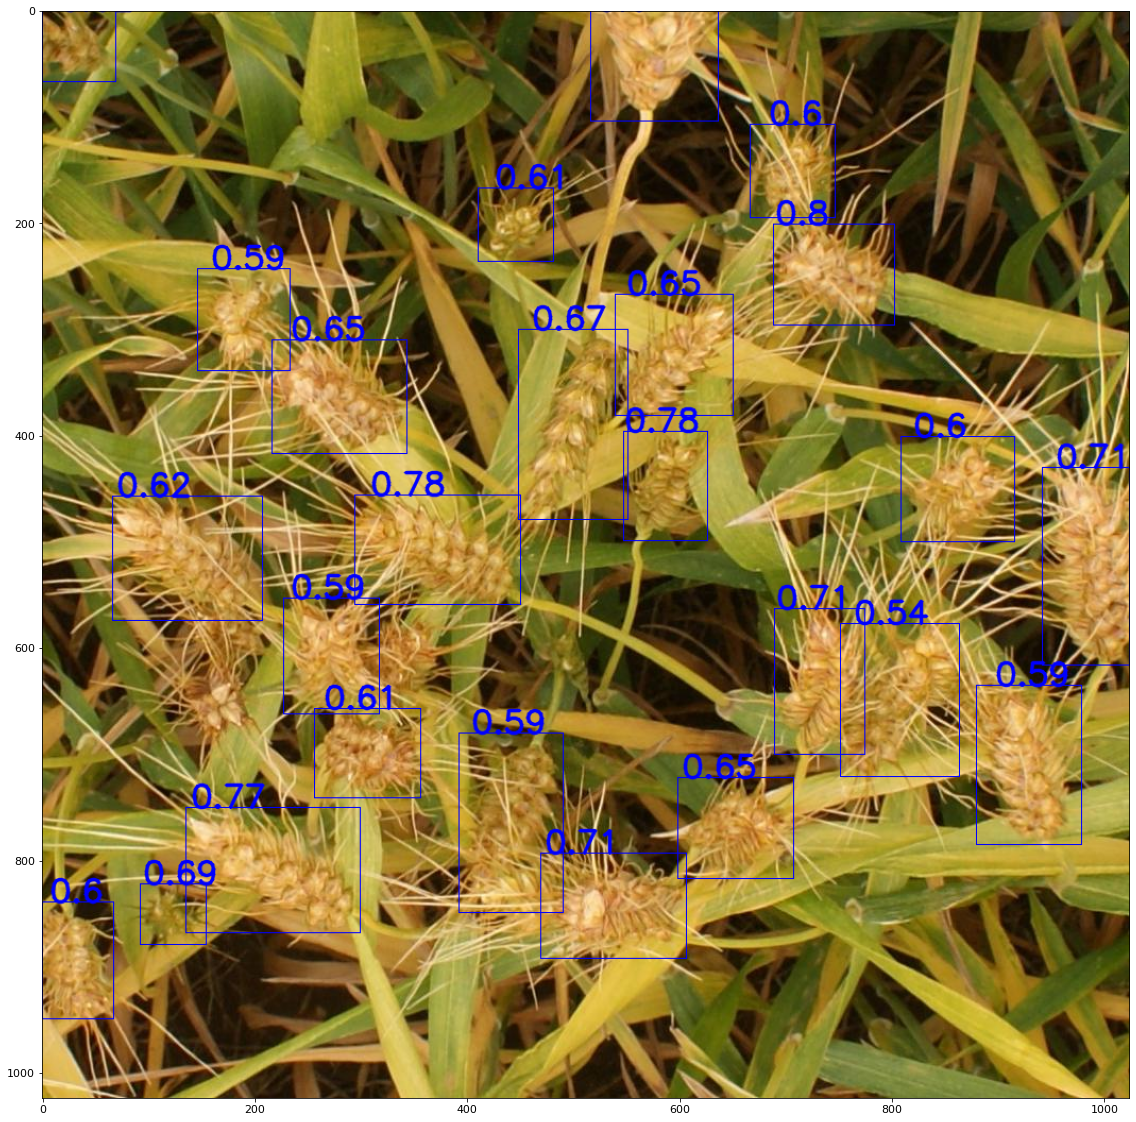

In [ ]:
size = 300
idx =-1
font = cv2.FONT_HERSHEY_SIMPLEX 
image = image = cv2.imread(all_path[idx], cv2.IMREAD_COLOR)
# fontScale 
fontScale = 1
# boxes = all_bboxex[idx]
# scores = all_score[idx]
# Blue color in BGR 
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2
for b,s in zip(boxes,scores):
    image = cv2.rectangle(image, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), (255,0,0), 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (b[0]+np.random.randint(20),b[1]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()

In [ ]:
3